# Trabajo práctico N°2 - Predicción de lluvia en Australia

---
Aprendizaje Automático I

Tecnicatura Universitaria en Inteligencia Artificial

Facultad de Ciencias Exactas, Ingeniería y Agrimensura

Universidad Nacional de Rosario

2025

Estudiantes:

*   Facundo Geuna
*   Máximo Alva
*   Marco Ippolito

# Parte Uno

## Librerías y funciones

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from folium import Map, Marker, Icon
from folium.plugins import MarkerCluster

In [71]:
# Creamos esta función para separar las palabras de las ciudades con nombres compuestos para que Geopy pueda hallarlas
def SepararCamelCase(cadena: str) -> str:
  """
  Recibe una cadena y le agrega espacios antes de cada mayúscula,
  exceptuando el primer caracter. Devuelve la cadena trasnformada.
  """
  resultado = ""
  for i, caracter in enumerate(cadena):
    if i > 0 and caracter.isupper() and cadena[i-1].islower():
      resultado += " "
    resultado += caracter
  return resultado

In [72]:
# Crear un boxplot para cada variable
def BoxplotDeLista(lista: list) -> None:
  """
  Recibe una lista de 6 variables y grafica un boxplot de
  cada una.
  """
  plt.figure(figsize=(16, 8))
  for i, var in enumerate(lista, 1):
      plt.subplot(2, 3, i)
      sns.boxplot(x=df[var], color='olivedrab')
      plt.title(f"Boxplot de {var}")
      plt.xlabel("")

## Carga de datos

In [73]:
!gdown 1t-VE5vs0WVeC9Pc5mztbGeBvM5TuLC6d
df = pd.read_csv('weatherAUS.csv')

Downloading...
From: https://drive.google.com/uc?id=1t-VE5vs0WVeC9Pc5mztbGeBvM5TuLC6d
To: /content/weatherAUS.csv
100% 14.1M/14.1M [00:00<00:00, 37.4MB/s]


In [74]:
print(f"El dataset cuenta con {df.shape[0]} registros y {df.shape[1]} variables.")

El dataset cuenta con 145460 registros y 23 variables.


In [75]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Regiones

En primer lugar, identificaremos todas las ciudades pertenecientes a nuestro dataset para luego, con ayuda de la librería *geopy*, encontrar las latitudes y longitudes correspondientes a cada localización y volcarlas en un dataset de referencia.

In [76]:
ciudades = df['Location'].unique()

In [77]:
# Inicializar geolocalizador
geolocator = Nominatim(user_agent="climate_region_clustering")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)  # evita baneos por rate limit
# Obtener coordenadas
coords = []
contador = 0
for ciudad in ciudades:
  location = geocode(f"{SepararCamelCase(ciudad)}, Australia")
  if location:
    lat = location.latitude
    lon = location.longitude
    coords.append((ciudad, lat, lon))
    contador += 1
  else:
    print(f"No se encontró: {ciudad}")
    coords.append((ciudad, None, None))

df_coords = pd.DataFrame(coords, columns=["Location", "Latitude", "Longitude"])
print(f"Se cargaron correctamente {contador} ciudades.")

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 1395, in getresponse
    response.begin()
  File "/usr/lib/python3.11/http/client.py", line 325, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 286, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ssl.py", line

Se cargaron correctamente 49 ciudades.


In [78]:
df_coords.head()

,Location,Latitude,Longitude
0,Albury,-36.073773,146.913526
1,BadgerysCreek,-33.883145,150.742466
2,Cobar,-31.966663,145.304505
3,CoffsHarbour,-30.298600,153.109412
4,Moree,-29.461720,149.840715


In [79]:
map = Map(location=[-25.0, 133.0], zoom_start=4)
for _, row in df_coords.iterrows():
  Marker(
    location=[row['Latitude'], row['Longitude']],
    popup=row['Location'],
    icon=Icon()
  ).add_to(map)
map

Utilizando el algoritmo K-means, agruparemos las localizaciones en clústers teniendo en cuenta las latitudes y longitudes de cada una.

In [80]:
# Aplicar KMeans sobre latitud y longitud
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
df_coords["Region"] = kmeans.fit_predict(df_coords[["Latitude", "Longitude"]])

In [81]:
df_coords.head()

,Location,Latitude,Longitude,Region
0,Albury,-36.073773,146.913526,0
1,BadgerysCreek,-33.883145,150.742466,9
2,Cobar,-31.966663,145.304505,0
3,CoffsHarbour,-30.298600,153.109412,7
4,Moree,-29.461720,149.840715,7


In [82]:
colores = ['red', 'pink', 'green', 'purple', 'orange', 'darkred', 'darkgreen', 'darkblue', 'black', 'blue', 'lightgray', 'beige']

map = Map(location=[-25.0, 133.0], zoom_start=4)
for _, row in df_coords.iterrows():
  # Elegir el color según el cluster
  color = colores[row['Region'] % len(colores)]
  Marker(
    location=[row['Latitude'], row['Longitude']],
    popup=f"{row['Location']} (Cluster {row['Region']})",
    icon=Icon(color=color)
  ).add_to(map)
map

In [83]:
# Agregar Region al df original
df = df.merge(df_coords[['Location', 'Region']], on='Location', how='left')

In [84]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Region
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0


## Análisis descriptivo

El dataset weatherAUS.csv contiene información climática de Australia de los
últimos diez años.

---

Variables:

1.   **Date**: fecha del registro climático.
2.   **Location**: localidad donde se obtuvo la observación.
1.   **MinTemp**: temperatura mínima del día (*°C*).
2.   **MaxTemp**: temperatura máxima del día (*°C*).
1.   **Rainfall**: cantidad de lluvia registrada en el día (*mm*).
2.   **Evaporation**: evaporación del día (*mm*)
1.   **Sunshine**: número de horas soleadas del día.
2.   **WindGustDir**: dirección de la ráfaga de viento más fuerte del día.
1.   **WindGustSpeed**: velocidad de la ráfaga de viento más fuerte del día (*km/h*).
2.   **WindDir9am**: dirección del viento a las 9 a.m.
1.   **WindDir3pm**: dirección del viento a las 3 p.m.
2.   **WindSpeed9am**: velocidad del viento a las 9 a.m. (*km/h*).
1.   **WindSpeed3pm**: velocidad del viento a las 3 p.m. (*km/h*).
2.   **Humidity9am**: humedad a las 9 a.m. (*%*).
1.   **Humidity3pm**: humedad a las 3 p.m. (*%*).
2.   **Pressure9am**: presión atmosférica a las 9 a.m. (*hpa*).
1.   **Pressure3pm**: presión atmosférica a las 3 p.m. (*hpa*).
2.   **Cloud9am**: nubosidad a las 9 a.m. (*octavos*).
1.   **Cloud3pm**: nubosidad a las 3 p.m. (*octavos*).
2.   **Temp9am**: temperatura a las 9 a.m. (*°C*).
1.   **Temp3pm**: temperatura a las 3 p.m. (*°C*).
2.   **RainToday**: Booleano. '*Yes*' si llovió, '*No*' en caso contrario.
1.   **RainTomorrow**: Booleano. '*Yes*' si llovió, '*No*' en caso contrario.

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Observamos que hay muchas filas con muchos datos nulos en simultáneo. Procederemos a eliminar las filas con más de 10 valores nulos, estás son 2789, es decir, aproximadamente el 1.92% de nuestros datos.

In [86]:
# Filas con más de 10 valores nulos en simultáneo
print(f"Cantidad de filas con más de 10 valores nulos: {len(df[df.isna().sum(axis=1) > 10])}")
df = df[df.isna().sum(axis=1) < 11]

Cantidad de filas con más de 10 valores nulos: 2789


### Variables categóricas

In [87]:
categoricas = [var for var in df.columns if df[var].dtype=='O']
print(f"El dataset cuenta con {len(categoricas)} variables categóricas. Estas son:\n{categoricas}")

El dataset cuenta con 7 variables categóricas. Estas son:
['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [88]:
print(df[categoricas].isnull().sum())

Date               0
Location           0
WindGustDir     8225
WindDir9am      8835
WindDir3pm      2258
RainToday       2141
RainTomorrow    2273
dtype: int64


Observamos que, de las variables categóricas, cinco contienen datos faltantes, siendo WindGustDir y WindDir9am las que presentan mayor cantidad.

#### Date

Transformamos la variable Date en tres variables separadas Year, Month y Day para poder trabajar mejor.

In [89]:
# Pasamos la variable Date a tipo datetime64
df["Date"] = pd.to_datetime(df["Date"])
# Creamos las tres nuevas variables Year, Month y Day
df["Year"] = pd.to_datetime(df["Date"]).dt.year
df["Month"] = pd.to_datetime(df["Date"]).dt.month
df["Day"] = pd.to_datetime(df["Date"]).dt.day
# Eliminamos la variable original
df.drop('Date', axis=1, inplace = True)

<ipython-input-89-1c538bbfe17d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
<ipython-input-89-1c538bbfe17d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Year"] = pd.to_datetime(df["Date"]).dt.year


#### Location y Region

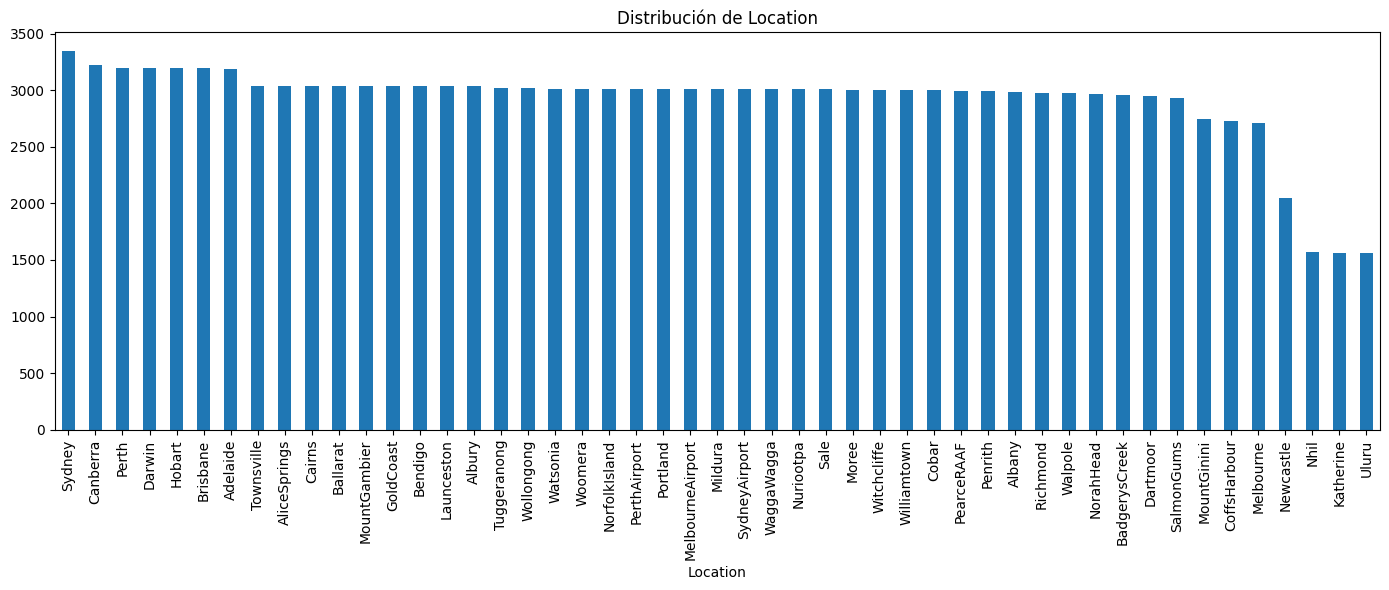

In [90]:
df['Location'].value_counts().plot(kind='bar', figsize=(14, 6))
plt.title("Distribución de Location")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

De ahora en más, trabajaremos con las regiones resultantes, en vez de con cada localidad en particular. La idea es reducir la dimensionalidad en nuestro futuro modelo y además imputar los datos necesarios encontrando estadísticos por región y no generales.

In [91]:
df = df.drop(columns=['Location'])

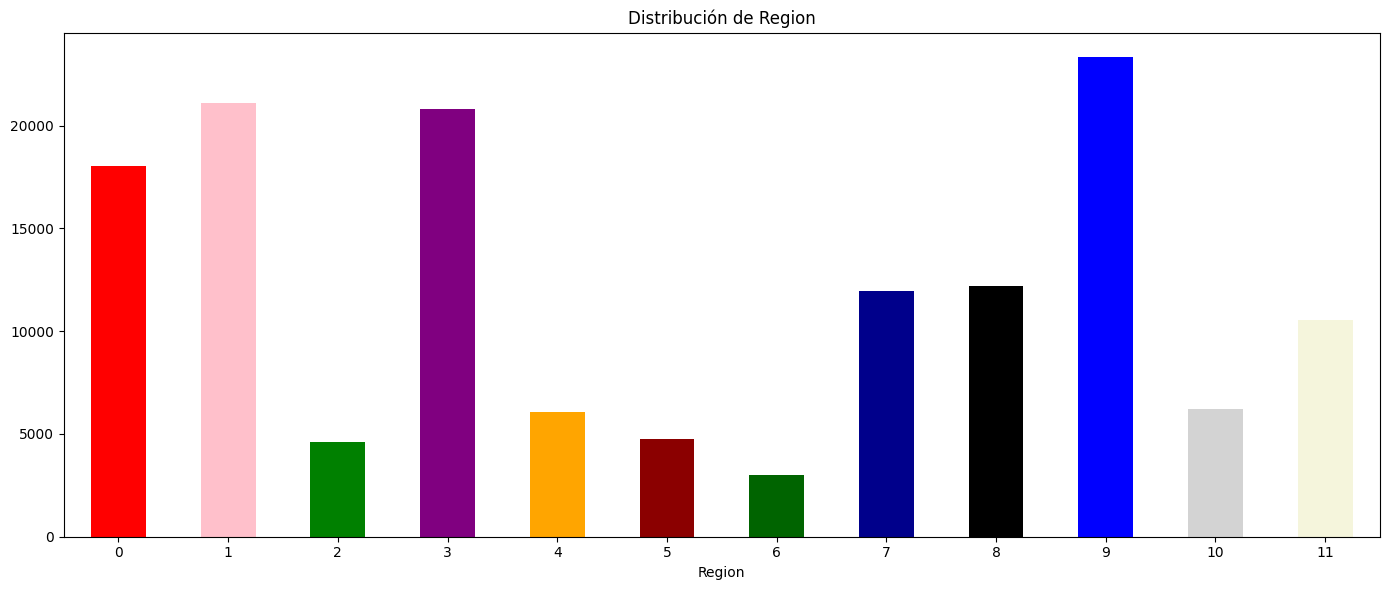

In [92]:
df['Region'].value_counts().sort_index().plot(kind='bar', figsize=(14, 6), color=colores)
plt.title("Distribución de Region")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### WindGustDir, WindDir9am y WindDir3pm

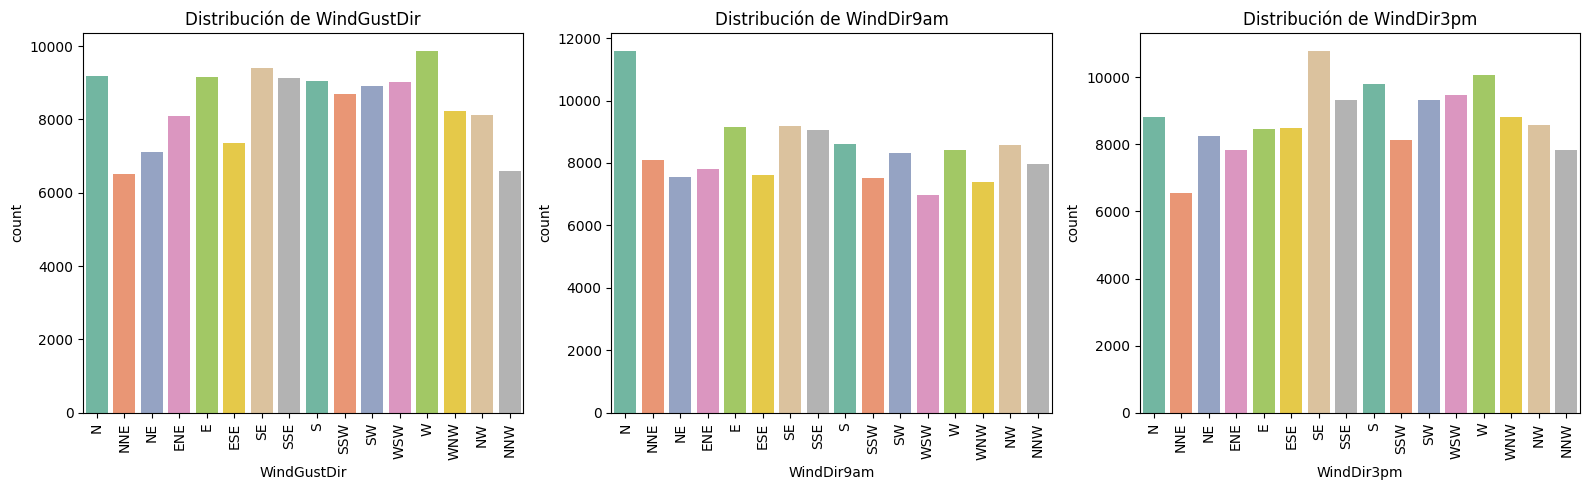

In [93]:
order = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
palette = dict(zip(order, sns.color_palette("Set2", n_colors=16)))
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
# Gráfico WindGustDir
sns.countplot(ax=axes[0], data=df, x="WindGustDir", hue="WindGustDir", palette=palette, order=order, legend=False)
axes[0].set_title("Distribución de WindGustDir")
axes[0].tick_params(axis='x', rotation=90)
# Gráfico WindDir9am
sns.countplot(ax=axes[1], data=df, x="WindDir9am", hue="WindDir9am", palette=palette, order=order, legend=False)
axes[1].set_title("Distribución de WindDir9am")
axes[1].tick_params(axis='x', rotation=90)
# Gráfico WindDir9am
sns.countplot(ax=axes[2], data=df, x="WindDir3pm", hue="WindDir3pm", palette=palette, order=order, legend=False)
axes[2].set_title("Distribución de WindDir3pm")
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

#### RainToday y RainTomorrow

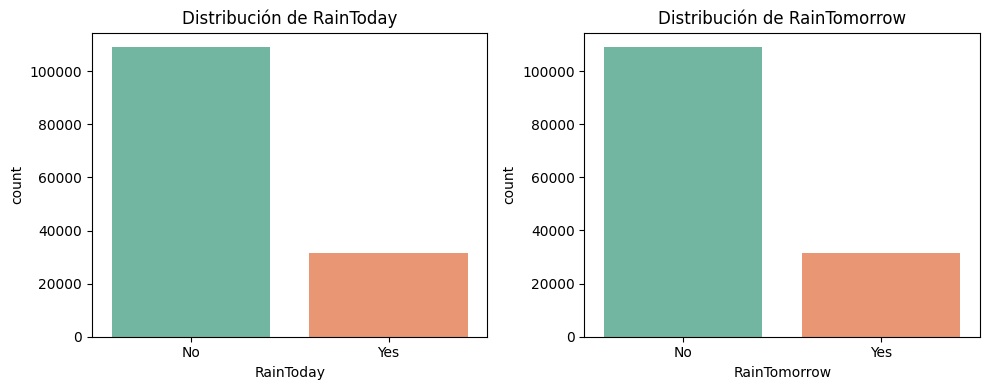

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Gráfico RainToday
sns.countplot(ax=axes[0], data=df, x="RainToday", hue="RainToday", palette="Set2", legend=False)
axes[0].set_title("Distribución de RainToday")
# Gráfico RainTomorrow
sns.countplot(ax=axes[1], data=df, x="RainTomorrow", hue="RainTomorrow", palette="Set2", legend=False)
axes[1].set_title("Distribución de RainTomorrow")

plt.tight_layout()
plt.show()

La distribución de las variables binarias RainToday y RainTomorrow son muy similares, con una gran predominancia a favor de los registros con 'No'. La presencia de cada categoría de nuestra variable objetivo está desbalanceada.




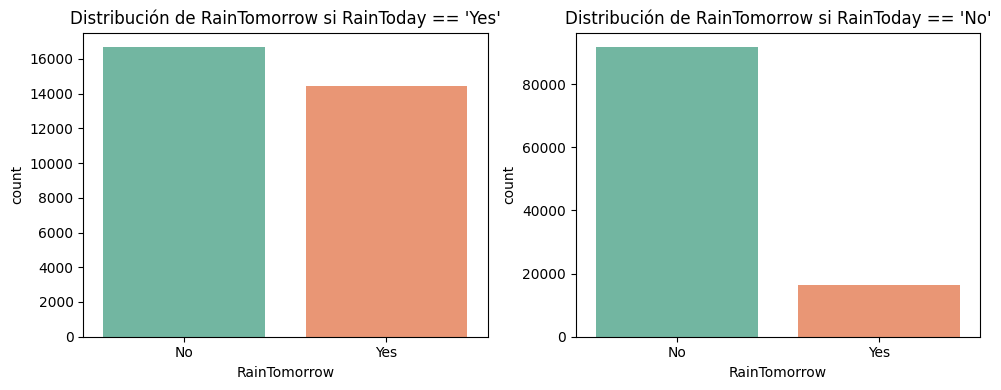

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Gráfico RainTomorrow cuando RainToday == 'Yes'
RainTodayYes = df[df['RainToday'] == 'Yes']
sns.countplot(ax=axes[0], data=RainTodayYes, x="RainTomorrow", hue="RainTomorrow", palette="Set2", legend=False)
axes[0].set_title("Distribución de RainTomorrow si RainToday == 'Yes'")
# Gráfico RainTomorrow cuando RainToday == 'No'
RainTodayNo = df[df['RainToday'] == 'No']
sns.countplot(ax=axes[1], data=RainTodayNo, x="RainTomorrow", hue="RainTomorrow", palette="Set2", legend=False)
axes[1].set_title("Distribución de RainTomorrow si RainToday == 'No'")

plt.tight_layout()
plt.show()

También, la variable RainTomorrow cuenta, a esta altura del análisis, con 2273 registros nulos lo cual representa aproximadamente el 1.59% de nuestros datos. Al tratarse de la variable objetivo, no podremos usar estos registros para entrenar  nuestro modelo, ni tampoco es conveniente imputar valores, por lo que procederemos a eliminarlos.

In [96]:
nan_RainTomorrow = int(df['RainTomorrow'].isna().sum())
print(f"Valores nulos de la variable RainTomorrow: {nan_RainTomorrow}")
print(f"Porcentaje del total de datos que representan: {nan_RainTomorrow/len(df)*100:.2f}%")
# Eliminación
df = df[df['RainTomorrow'].notna()]

Valores nulos de la variable RainTomorrow: 2273
Porcentaje del total de datos que representan: 1.59%


Por último, resolvimos codificar estas variables binarias con el siguiente mapeo:


*   No --> 0
*   Yes --> 1

No olvidar que en la variable RainToday siguen existiendo datos faltantes los cuales deberemos trabajar previo al entrenamiento.

In [97]:
df["RainTomorrow"] = df["RainTomorrow"].map({"No": 0, "Yes": 1})
df["RainToday"] = df["RainToday"].map({"No": 0, "Yes": 1})

<ipython-input-97-7b420a7d0ef5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RainTomorrow"] = df["RainTomorrow"].map({"No": 0, "Yes": 1})
<ipython-input-97-7b420a7d0ef5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RainToday"] = df["RainToday"].map({"No": 0, "Yes": 1})


In [98]:
df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Region', 'Year', 'Month',
       'Day'],
      dtype='object')

### Variables numéricas

In [99]:
numericas = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
            'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
            'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
print(f"El dataset cuenta con {len(numericas)} variables numéricas. Estas son:\n{numericas}")

El dataset cuenta con 16 variables numéricas. Estas son:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [100]:
print(df[numericas].isnull().sum())

MinTemp            267
MaxTemp            181
Rainfall          1161
Evaporation      59293
Sunshine         66050
WindGustSpeed     7668
WindSpeed9am       376
WindSpeed3pm      1091
Humidity9am       1270
Humidity3pm       2546
Pressure9am      12293
Pressure3pm      12309
Cloud9am         52630
Cloud3pm         55365
Temp9am            424
Temp3pm           1676
dtype: int64


Como podemos comprobar, todas nuestras variables numéricas contienen datos faltantes.

In [101]:
round(df[numericas].describe(), 2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,140131.00,140217.00,139237.00,81105.00,74348.00,132730.00,140022.00,139307.00,139128.00,137852.00,128105.00,128089.00,87768.00,85033.00,139974.00,138722.00
mean,12.19,23.23,2.34,5.47,7.62,39.98,14.03,18.64,68.82,51.48,1017.65,1015.26,4.44,4.50,16.98,21.70
std,6.40,7.12,8.43,4.19,3.78,13.58,8.87,8.80,19.07,20.79,7.11,7.04,2.89,2.72,6.50,6.93
min,-8.50,-4.80,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,980.50,977.10,0.00,0.00,-7.20,-5.40
25%,7.60,17.90,0.00,2.60,4.90,31.00,7.00,13.00,57.00,37.00,1012.90,1010.40,1.00,2.00,12.30,16.60
50%,12.00,22.60,0.00,4.80,8.50,39.00,13.00,19.00,70.00,52.00,1017.60,1015.20,5.00,5.00,16.70,21.10
75%,16.80,28.30,0.80,7.40,10.60,48.00,19.00,24.00,83.00,66.00,1022.40,1020.00,7.00,7.00,21.60,26.40
max,33.90,48.10,371.00,145.00,14.50,135.00,87.00,87.00,100.00,100.00,1041.00,1039.60,9.00,9.00,40.20,46.70


A simple vista, notamos que las variables Rainfall, Evaporation, WindSpeed9am y WindSpeed3pm pueden contener valores atípicos.

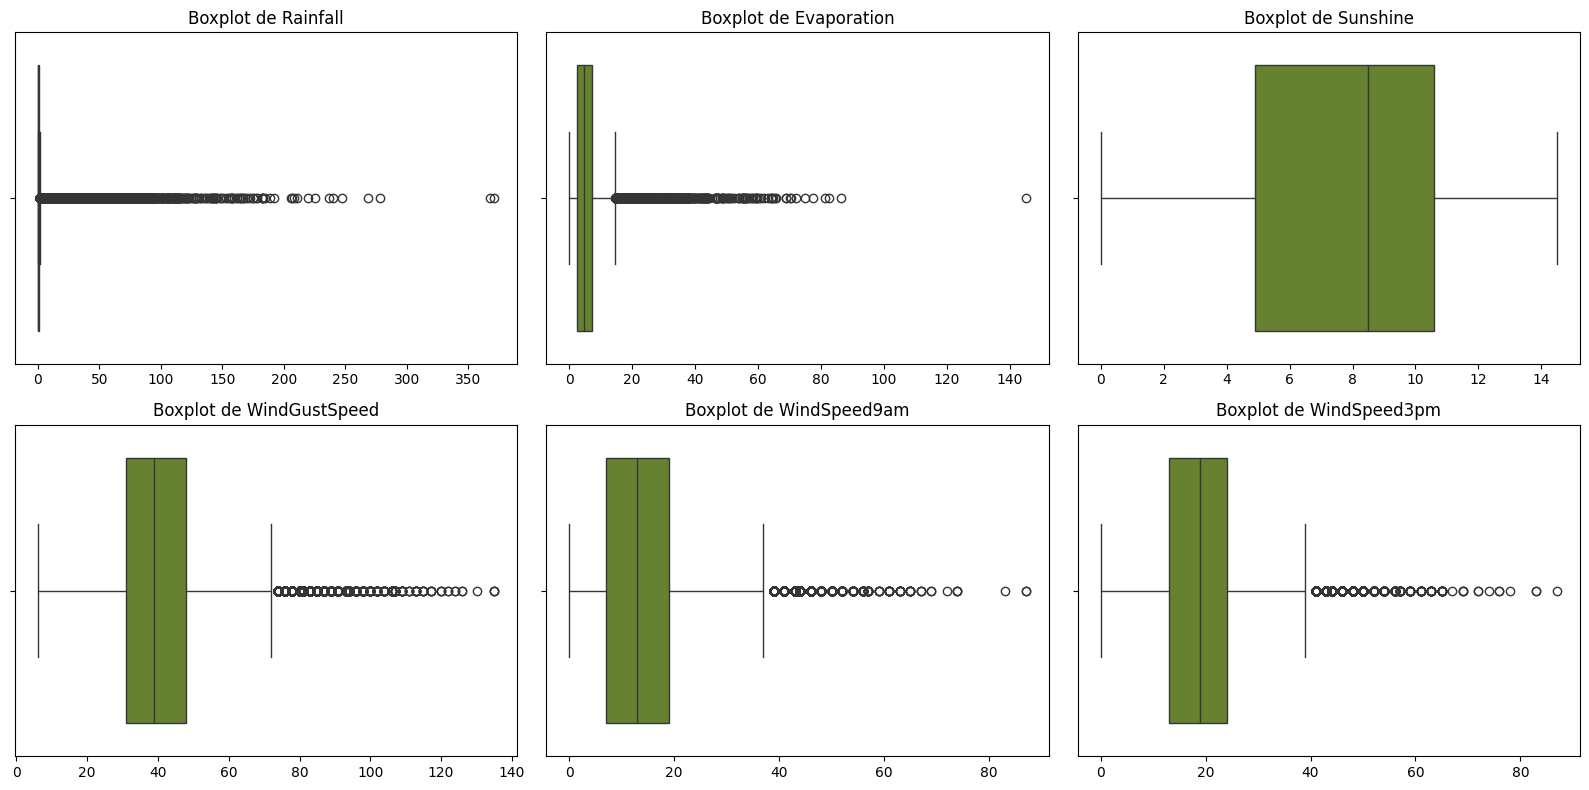

In [102]:
vars1 = ['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']
BoxplotDeLista(vars1)
plt.tight_layout()
plt.show()

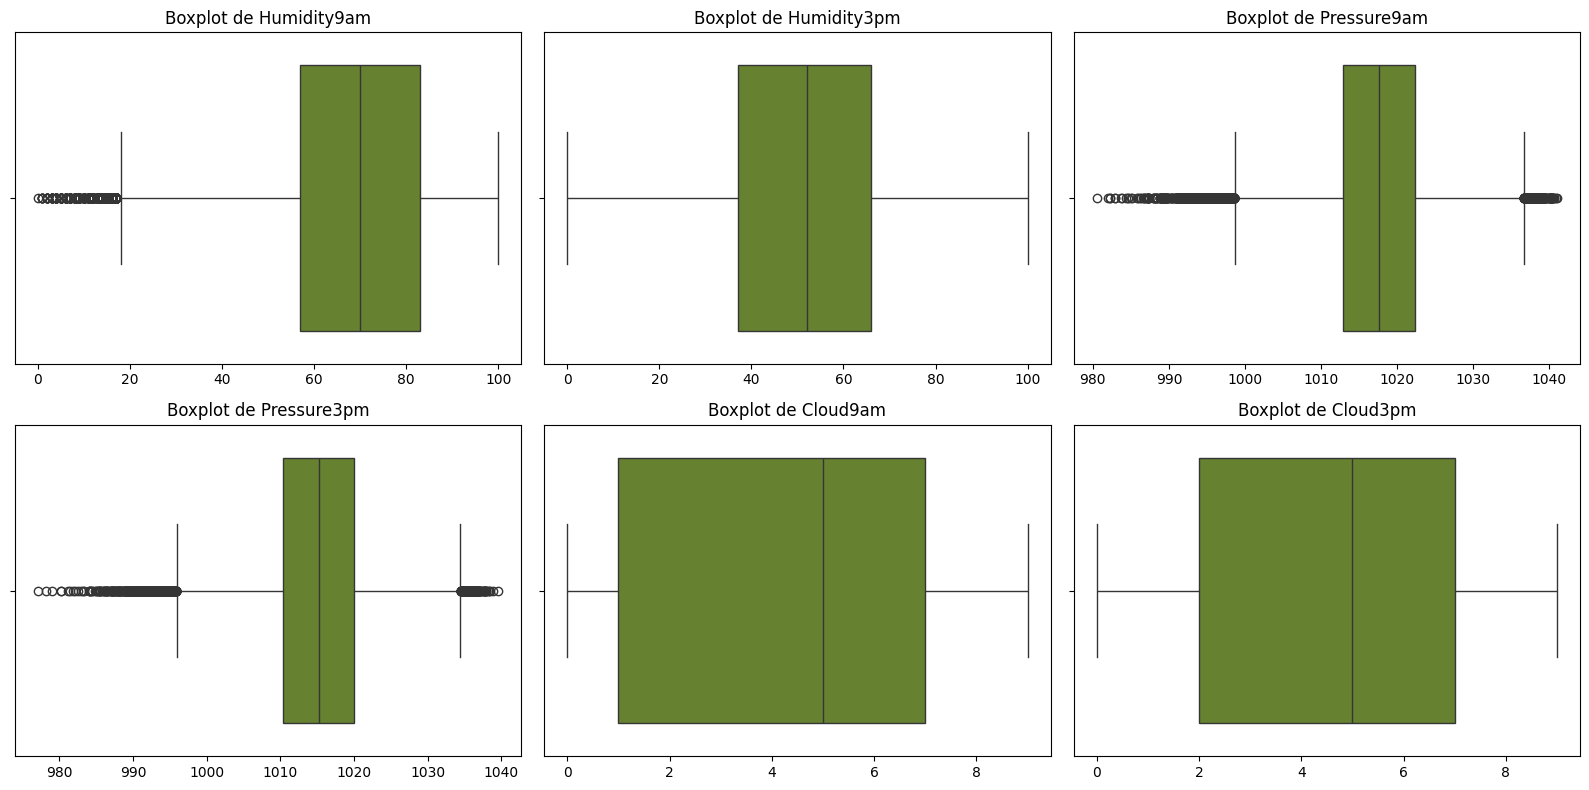

In [103]:
vars2 = ['Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
BoxplotDeLista(vars2)
plt.tight_layout()
plt.show()

#### MinTemp, MaxTemp, Temp9am y Temp3pm

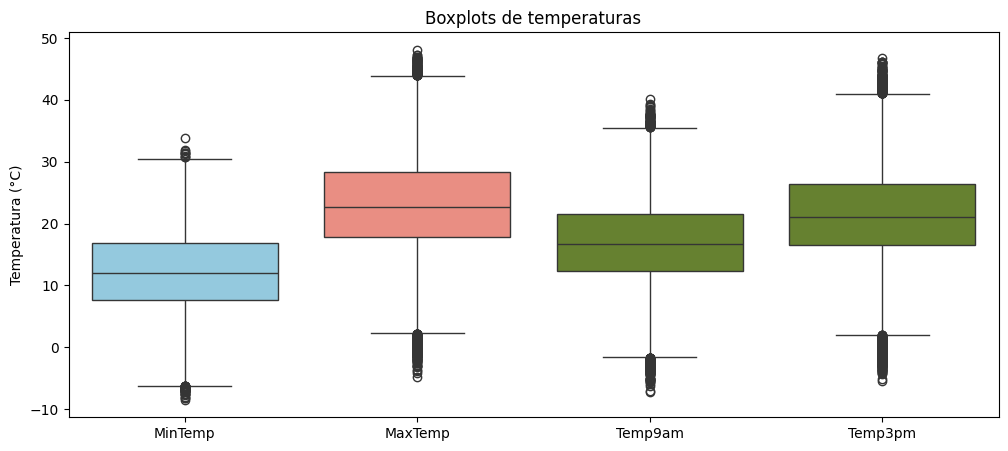

In [104]:
df_melted = df[['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']].melt(var_name='Tipo', value_name='Temperatura')

plt.figure(figsize=(12, 5))
sns.boxplot(x='Tipo', y='Temperatura', data=df_melted, hue='Tipo', palette=['skyblue', 'salmon', 'olivedrab', 'olivedrab'], legend=False)
plt.title('Boxplots de temperaturas')
plt.xlabel(''), plt.ylabel('Temperatura (°C)')
plt.show()

#### Matriz de correlación

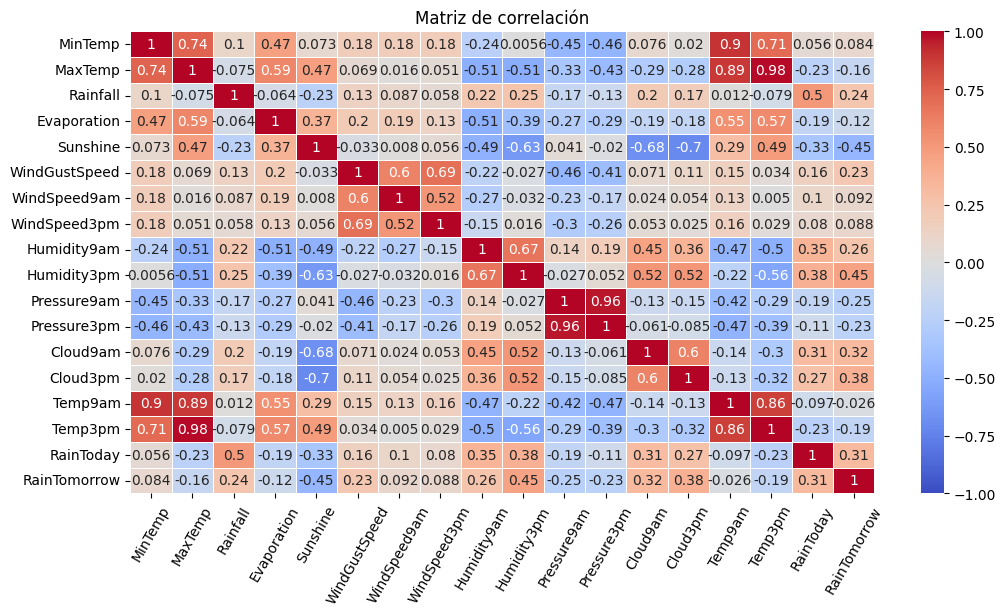

In [105]:
plt.figure(figsize=(12, 6))
sns.heatmap(df[numericas + ["RainToday", "RainTomorrow"]].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='coolwarm')
plt.title("Matriz de correlación"), plt.xticks(rotation=60)
plt.show()

## División del dataset en conjuntos de entrenamiento y prueba

In [106]:
X = df.drop(['RainTomorrow'], axis=1)
y = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Imputación de datos faltantes

En primer lugar, imputaremos los datos faltantes de las variables numéricas utilizando la mediana por región calculada exclusivamente a partir del conjunto de entrenamiento. Optamos por la mediana debido a su robustez frente a valores atípicos. A su vez, la decisión de calcularla por región fue tomada buscando preservar patrones locales relevantes que podrían verse sesgados si se empleara una mediana global.

In [107]:
for df in [X_train, X_test]:
  for variable in numericas:
    # Calcular la mediana por región en X_train
    mediana_region = X_train.groupby('Region')[variable].median()
    # Imputar los nulos con la mediana correspondiente a su región
    df[variable] = df.apply(
      lambda row: mediana_region[row['Region']] if pd.isnull(row[variable]) else row[variable],
      axis=1
    )

Ahora, imputaremos los datos faltantes de las variables categóricas utilizando la moda por región de cada una en el conjunto de entrenamiento.

In [108]:
for df in [X_train, X_test]:
  for variable in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']:
    moda_region = X_train.groupby('Region')[variable].agg(lambda x: x.mode().iloc[0])
    df[variable] = df.apply(
      lambda row: moda_region[row['Region']] if pd.isnull(row[variable]) else row[variable],
      axis=1
    )

In [109]:
print(X_train.isnull().sum())

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Region           0
Year             0
Month            0
Day              0
dtype: int64


In [110]:
print(X_test.isnull().sum())

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Region           0
Year             0
Month            0
Day              0
dtype: int64


In [111]:
df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'Region', 'Year', 'Month', 'Day'],
      dtype='object')

## Codificación de variables categóricas

Realizamos one-hot enconding para cada una de las 12 regiones de la variable Region. El parámetro *drop_first=True* elimina una de las categorías de la variable para evitar colinealidad.

In [112]:
RegionDummiesTrain = pd.get_dummies(X_train["Region"], prefix="Region", drop_first=True)
X_train = pd.concat([X_train.drop(columns="Region"), RegionDummiesTrain], axis=1)

RegionDummiesTest = pd.get_dummies(X_test["Region"], prefix="Region", drop_first=True)
X_test = pd.concat([X_test.drop(columns="Region"), RegionDummiesTest], axis=1)

RegionDummiesTrain.head()

,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10,Region_11
94054,False,False,False,True,False,False,False,False,False,False,False
73203,False,False,False,False,False,False,False,True,False,False,False
55168,False,False,True,False,False,False,False,False,False,False,False
113203,True,False,False,False,False,False,False,False,False,False,False
121553,True,False,False,False,False,False,False,False,False,False,False


De la misma manera, continuamos realizando la codificación one-hot de las variables WindGustDir, WindDir9am y WindDir3pm

In [113]:
WindGustDirDummiesTrain = pd.get_dummies(X_train["WindGustDir"], prefix="WindGustDir", drop_first=True)
X_train = pd.concat([X_train.drop(columns="WindGustDir"), WindGustDirDummiesTrain], axis=1)

WindGustDirDummiesTest = pd.get_dummies(X_test["WindGustDir"], prefix="WindGustDir", drop_first=True)
X_test = pd.concat([X_test.drop(columns="WindGustDir"), WindGustDirDummiesTest], axis=1)

WindGustDirDummiesTrain.head()

,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW
94054,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
73203,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
55168,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
113203,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
121553,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [114]:
WindDir9amDummiesTrain = pd.get_dummies(X_train["WindDir9am"], prefix="WindDir9am", drop_first=True)
X_train = pd.concat([X_train.drop(columns="WindDir9am"), WindDir9amDummiesTrain], axis=1)

WindDir9amDummiesTest = pd.get_dummies(X_test["WindDir9am"], prefix="WindDir9am", drop_first=True)
X_test = pd.concat([X_test.drop(columns="WindDir9am"), WindDir9amDummiesTest], axis=1)

WindDir9amDummiesTrain.head()

,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
94054,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
73203,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
55168,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
113203,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
121553,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [115]:
WindDir3pmDummiesTrain = pd.get_dummies(X_train["WindDir3pm"], prefix="WindDir3pm", drop_first=True)
X_train = pd.concat([X_train.drop(columns="WindDir3pm"), WindDir3pmDummiesTrain], axis=1)

WindDir3pmDummiesTest = pd.get_dummies(X_test["WindDir3pm"], prefix="WindDir3pm", drop_first=True)
X_test = pd.concat([X_test.drop(columns="WindDir3pm"), WindDir3pmDummiesTest], axis=1)

WindDir3pmDummiesTrain.head()

,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
94054,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
73203,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
55168,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
113203,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
121553,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [116]:
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
94054,24.9,31.8,0.0,5.4,8.1,41.0,13.0,20.0,69.0,63.0,...,False,False,False,False,False,False,False,False,False,False
73203,8.7,23.9,0.4,5.4,9.0,37.0,20.0,17.0,56.0,25.0,...,False,False,True,False,False,False,False,False,False,False
55168,15.0,33.0,0.0,3.8,6.7,39.0,2.0,20.0,27.0,30.0,...,False,False,False,False,False,False,True,False,False,False
113203,12.6,17.7,2.6,4.4,9.1,46.0,13.0,13.0,59.0,67.0,...,False,False,False,False,False,False,False,False,True,False
121553,18.7,39.0,0.0,12.0,12.5,41.0,15.0,7.0,42.0,26.0,...,False,False,False,False,False,False,False,False,False,False


In [117]:
X_test.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
102033,15.7,23.0,1.2,6.2,6.5,37.0,20.0,24.0,68.0,56.0,...,False,False,False,False,False,True,False,False,False,False
83909,13.5,31.9,0.0,2.8,6.5,31.0,4.0,19.0,85.0,39.0,...,False,False,False,True,False,False,False,False,False,False
31548,15.6,21.1,0.0,7.2,3.9,63.0,20.0,28.0,70.0,72.0,...,False,False,False,False,True,False,False,False,False,False
129578,9.0,14.6,9.2,4.4,9.1,65.0,24.0,26.0,67.0,81.0,...,False,False,False,False,False,False,False,False,False,True
99104,10.6,21.4,0.4,5.4,9.0,24.0,9.0,11.0,84.0,43.0,...,True,False,False,False,False,False,False,False,False,False


## Escalado de datos

In [118]:
scaler = StandardScaler().set_output(transform="pandas")
X_train[numericas] = scaler.fit_transform(X_train[numericas])
X_test[numericas] = scaler.transform(X_test[numericas])

In [119]:
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
94054,1.985336,1.204149,-0.278220,0.094463,0.049512,0.082694,-0.115219,0.156268,0.009004,0.559962,...,False,False,False,False,False,False,False,False,False,False
73203,-0.544614,0.093366,-0.230123,0.094463,0.362888,-0.219962,0.674812,-0.186035,-0.674452,-1.282253,...,False,False,True,False,False,False,False,False,False,False
55168,0.439255,1.372876,-0.278220,-0.392419,-0.437963,-0.068634,-1.356697,0.156268,-2.199084,-1.039856,...,False,False,False,False,False,False,True,False,False,False
113203,0.064448,-0.778388,0.034409,-0.209838,0.397708,0.461015,-0.115219,-0.642437,-0.516731,0.753879,...,False,False,False,False,False,False,False,False,True,False
121553,1.017083,2.216508,-0.278220,2.102852,1.581576,0.082694,0.110504,-1.327042,-1.410481,-1.233774,...,False,False,False,False,False,False,False,False,False,False


In [120]:
X_test.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
102033,0.548574,-0.033179,-0.133930,0.337904,-0.507603,-0.219962,0.674812,0.612670,-0.043570,0.220607,...,False,False,False,False,False,True,False,False,False,False
83909,0.205000,1.218210,-0.278220,-0.696720,-0.507603,-0.673947,-1.130973,0.042167,0.850180,-0.603542,...,False,False,False,True,False,False,False,False,False,False
31548,0.532957,-0.300329,-0.278220,0.642205,-1.412913,1.747305,0.674812,1.069073,0.061577,0.996276,...,False,False,False,False,True,False,False,False,False,False
129578,-0.497764,-1.214264,0.828005,-0.209838,0.397708,1.898633,1.126259,0.840872,-0.096143,1.432590,...,False,False,False,False,False,False,False,False,False,True
99104,-0.247892,-0.258147,-0.230123,0.094463,0.362888,-1.203595,-0.566665,-0.870639,0.797607,-0.409625,...,True,False,False,False,False,False,False,False,False,False


## Regresión logística

In [121]:
# Inicializar y entrenar el modelo
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [122]:
# Predicciones sobre el conjunto de test
y_pred_test = model.predict(X_test)
y_pred_test

array([0, 0, 1, ..., 0, 0, 0])

In [123]:
# Probabilidades de pertenecer a cada clase
model.predict_proba(X_test)

array([[0.83762777, 0.16237223],
       [0.92455394, 0.07544606],
       [0.38548925, 0.61451075],
       ...,
       [0.6255155 , 0.3744845 ],
       [0.98469565, 0.01530435],
       [0.8869538 , 0.1130462 ]])

In [124]:
# Coeficientes asignados a cada variable
model.coef_

array([[ 7.20357440e-02, -1.89168647e-02,  8.45681264e-02,
        -2.36270004e-02, -3.28649291e-01,  7.72991932e-01,
        -1.36556543e-01, -2.70444227e-01,  1.28220439e-01,
         1.05585773e+00,  1.60953401e-01, -5.02596502e-01,
        -2.94931232e-02,  2.67632937e-01,  1.29131165e-01,
        -3.89065251e-02,  3.84031433e-01, -9.97415755e-04,
         1.26730695e-02, -1.20951055e-04,  4.25266623e-01,
         2.37639649e-02, -2.39048513e-01, -1.08200791e-01,
        -8.52129221e-02, -6.66777082e-02,  1.50643500e-01,
         1.20380240e-01, -2.43269875e-02, -2.20857646e-01,
        -9.78979428e-02, -2.81206393e-02, -6.92176472e-03,
         1.50024386e-01, -4.76951378e-02,  1.85079429e-02,
         9.41387885e-02,  9.29171022e-02, -5.91436981e-02,
        -4.76811161e-03, -4.07009684e-02, -8.57357928e-02,
        -4.70485432e-02,  1.12523459e-03,  3.93127036e-02,
        -3.30794156e-02,  5.73482417e-02, -6.68133066e-02,
         1.75932967e-01,  7.80519952e-02,  2.09892060e-0

In [125]:
# Predicciones sobre el conjunto de entrenamiento
y_pred_train = model.predict(X_train)
y_pred_train

array([0, 0, 0, ..., 0, 1, 0])

In [126]:
# Comparación de exactitud conjunto de test vs. conjunto  de entrenamiento
print("Accuracy conjunto de test:", accuracy_score(y_test, y_pred_test))
print("Accuracy conjunto de entrenamiento:", accuracy_score(y_train, y_pred_train))

Accuracy conjunto de test: 0.8438390313390314
Accuracy conjunto de entrenamiento: 0.8430972773731726


In [127]:
# Métricas generales predicciones sobre el conjunto de test
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     21816
           1       0.72      0.49      0.59      6264

    accuracy                           0.84     28080
   macro avg       0.79      0.72      0.74     28080
weighted avg       0.83      0.84      0.83     28080



<Figure size 600x400 with 0 Axes>

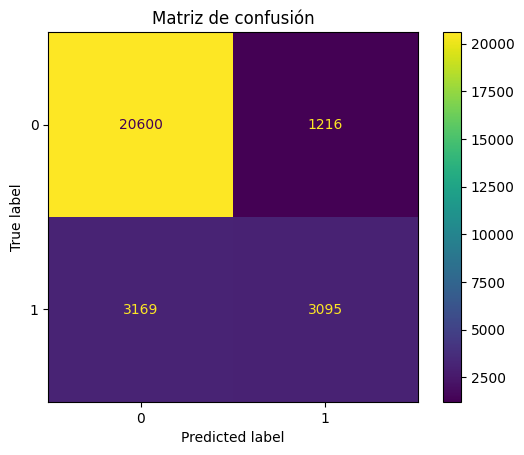

In [128]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
plt.figure(figsize=(6, 4))
disp.plot(values_format='d')
plt.title("Matriz de confusión")
plt.show()

In [129]:
print(f"Porcentaje de falsos positivos: {cm[0, 1] / (cm[0, 1] + cm[0, 0]) * 100:.4f} %")
print(f"Porcentaje de falsos negativos: {cm[1, 0] / (cm[1, 0] + cm[1, 1]) * 100:.4f} %")

Porcentaje de falsos positivos: 5.5739 %
Porcentaje de falsos negativos: 50.5907 %


Esto quiere decir que pocas veces nos dice que va a llover y no lo hace y que la mitad de las veces que llueve, el modelo no lo predice.

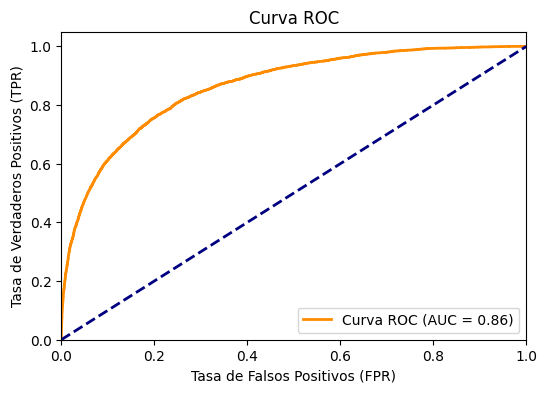

In [130]:
# Obtengo las probabilidades de predicción del modelo
y_proba_test = model.predict_proba(X_test)[:, 1]
# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [131]:
roc_auc

np.float64(0.8623782251043324)

In [132]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , ..., 0.98001467, 0.98001467,
        1.        ]),
 array([0.00000000e+00, 1.59642401e-04, 4.78927203e-03, ...,
        9.99840358e-01, 1.00000000e+00, 1.00000000e+00]),
 array([       inf, 0.99942766, 0.9873747 , ..., 0.00724699, 0.00724259,
        0.00153912]))

### Análisis del umbral en la curva ROC

El modelo de regresión logística utiliza por defecto un umbral de 0.5 para clasificar. Sin embargo, este valor **no siempre es el óptimo**, especialmente si el dataset está desbalanceado o si queremos priorizar recall sobre precisión (por ejemplo, evitar falsos negativos).

A partir de la curva ROC, se podrían calcular diferentes umbrales y elegir el mejor según algún criterio, como:

- El punto que maximiza la métrica **Youden's J**: `J = Sensibilidad + Especificidad - 1`
- El punto más cercano al vértice (0, 1) de la curva ROC.
- Aquel que maximice el F1-score evaluado para distintos thresholds.

En este caso, **usar 0.5 no es necesariamente el mejor**, ya que vimos un alto porcentaje de falsos negativos. Ajustar el umbral puede ayudar a equilibrar mejor las predicciones.


### ¿Se consiguió un buen fitting?

A partir de las métricas obtenidas, especialmente el alto porcentaje de **falsos negativos** y el bajo recall para la clase positiva, podemos concluir que **el modelo no consiguió un buen fitting**.

El **accuracy puede parecer aceptable ~76%**, esto se debe en parte al desbalance de clases (la mayoría de los días no llueve). El modelo tiende a **predecir mayoritariamente "No"**, y falla en detectar correctamente muchos días en los que sí llueve.

Esto sugiere que:

- El modelo está subajustado (underfitting), es decir, **no está captando bien los patrones** en los datos.
- Es necesario ajustar hiperparámetros, probar con otros modelos, o trabajar sobre el desbalance para mejorar el rendimiento general.

Un buen fitting se lograría cuando el modelo acierta tanto en días de lluvia como en días sin lluvia, con un balance entre precisión y recall.


#### Implementado del Modelo Base Basado en la Mayoría

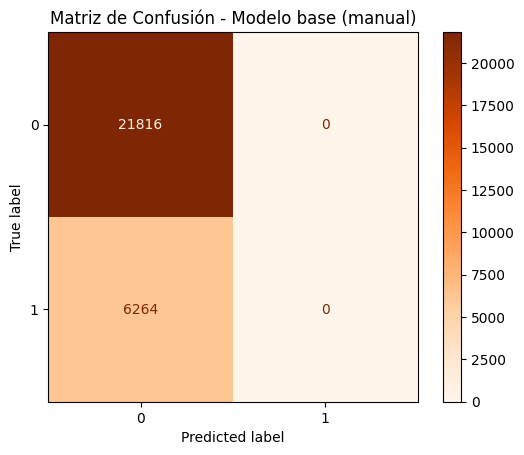

In [133]:
# Encontrar la clase más frecuente en el set de entrenamiento
clase_mayoritaria = y_train.value_counts().idxmax()

# Predecir esa clase para todo el conjunto de prueba
y_pred_base = [clase_mayoritaria] * len(y_test)

# Mostrar matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base, cmap="Oranges")
plt.title("Matriz de Confusión - Modelo base (manual)")
plt.show()

In [134]:
# Calcular y mostrar métricas
print("Reporte de métricas - Modelo base (predicción constante):")
print(classification_report(y_test, y_pred_base))

# Como no tenemos probabilidades, simulamos una probabilidad baja constante para curva ROC
# Asignamos una probabilidad 0.01 a la clase 'Yes', ya que siempre predice 'No'
y_proba_base = np.zeros(len(y_test)) + 0.01

Reporte de métricas - Modelo base (predicción constante):
              precision    recall  f1-score   support

           0       0.78      1.00      0.87     21816
           1       0.00      0.00      0.00      6264

    accuracy                           0.78     28080
   macro avg       0.39      0.50      0.44     28080
weighted avg       0.60      0.78      0.68     28080



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


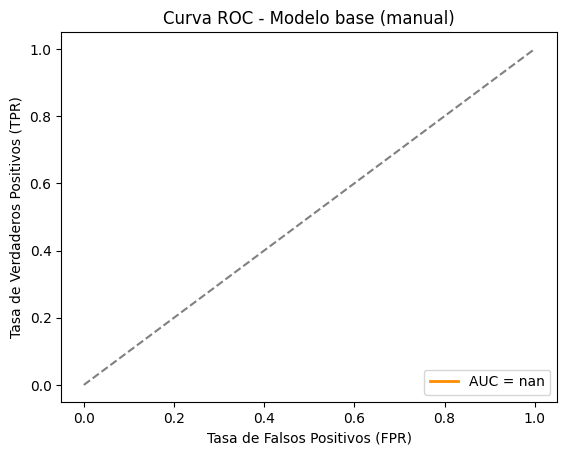

In [135]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_base, pos_label='Yes')
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Modelo base (manual)")
plt.legend(loc="lower right")
plt.show()

### Observación sobre la curva ROC del modelo base

El modelo base implementado predice siempre la misma clase ("No"), lo que significa que no genera probabilidades diferenciadas para clasificar los casos. Como consecuencia:

- Todos los valores de probabilidad son iguales.
- No se pueden calcular tasas de verdaderos o falsos positivos para distintos umbrales.
- La **curva ROC no se puede trazar**, y el **AUC resulta `nan`** (no definido).

#### Modelo Base Clasificador Aleatorio

<Figure size 600x400 with 0 Axes>

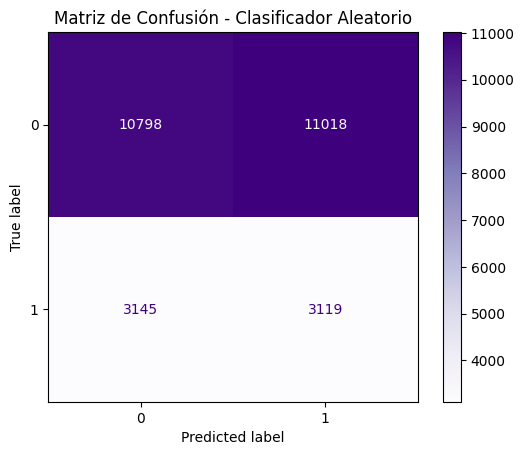

In [136]:
# Clasificador aleatorio: predice 0 o 1 al azar, sin mirar las proporciones
y_pred_random = np.random.choice([0, 1], size=len(y_test))

# Matriz de confusión
cm_2 = confusion_matrix(y_test, y_pred_random)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2)
plt.figure(figsize=(6, 4))
disp.plot(cmap="Purples", values_format='d')
plt.title("Matriz de Confusión - Clasificador Aleatorio")
plt.show()

In [137]:
# Reporte de métricas
print("Reporte de métricas - Clasificador Aleatorio:")
print(classification_report(y_test, y_pred_random))

Reporte de métricas - Clasificador Aleatorio:
              precision    recall  f1-score   support

           0       0.77      0.49      0.60     21816
           1       0.22      0.50      0.31      6264

    accuracy                           0.50     28080
   macro avg       0.50      0.50      0.45     28080
weighted avg       0.65      0.50      0.54     28080



In [138]:
print(f"Porcentaje de falsos positivos: {cm_2[0, 1] / (cm_2[0, 1] + cm_2[0, 0]) * 100:.4f} %")
print(f"Porcentaje de falsos negativos: {cm_2[1, 0] / (cm_2[1, 0] + cm_2[1, 1]) * 100:.4f} %")

Porcentaje de falsos positivos: 50.5042 %
Porcentaje de falsos negativos: 50.2075 %
